In [ ]:
%pip install librosa
%pip install numpy
%pip install aubio
%pip install transformers
%pip install networkx
%pip install nnAudio
%pip install audiocraft
%pip install pydub
%pip install tkinter
%apt-get install ffmpeg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 479.0/479.0 kB 17.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for aubio: filename=aubio-0.4.9-cp310-cp310-linux_x86_64.whl size=425316 sha256=1795206c5f9de38952f70885b02f2b3ce5ae32a4f416853fd3dfbf5eaa11d210
  Stored in directory: /root/.cache/pip/wheels/00/30/30/a06fe7e9c7fe740486c219851b2bc1c7ed4a97e9c257efd3d7
Successfully built aubio
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 635.7/635.7 kB 17.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.4/72.4 kB 7.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.6/59.6 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [ ]:
from audiocraft.models import MusicGen
from audiocraft.data.audio import audio_write
import librosa
import numpy as np
import aubio
import os
import pandas as pd
import networkx as nx
from scipy.signal import medfilt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from google.colab import drive
import torch
import torchaudio.transforms as T
import torchaudio
import collections
import sys
from sklearn.metrics.pairwise import cosine_similarity
import concurrent.futures
import matplotlib.pyplot as plt
import librosa.display
import torch
import torch.nn.functional as F
from IPython.display import Audio
from torch.cuda.amp import autocast
from transformers import AutoModel, AutoProcessor
import tqdm as tqdm
from scipy.spatial.distance import cosine
import soundfile as sf
from scipy.signal import butter, lfilter
from pydub import AudioSegment
import re

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#functin to get tone of the song
class Tonal_Fragment(object):
    def __init__(self, waveform, sr, tstart=None, tend=None):
        self.waveform = waveform
        self.sr = sr
        self.tstart = tstart
        self.tend = tend

        if self.tstart is not None:
            self.tstart = librosa.time_to_samples(self.tstart, sr=self.sr)
        if self.tend is not None:
            self.tend = librosa.time_to_samples(self.tend, sr=self.sr)
        self.y_segment = self.waveform[self.tstart:self.tend]
        self.chromograph = librosa.feature.chroma_cqt(y=self.y_segment, sr=self.sr, bins_per_octave=24)

        # chroma_vals is the amount of each pitch class present in this time interval
        self.chroma_vals = []
        for i in range(12):
            self.chroma_vals.append(np.sum(self.chromograph[i]))
        pitches = ['C','C#','D','D#','E','F','F#','G','G#','A','A#','B']
        # dictionary relating pitch names to the associated intensity in the song
        self.keyfreqs = {pitches[i]: self.chroma_vals[i] for i in range(12)}

        keys = [pitches[i] + ' major' for i in range(12)] + [pitches[i] + ' minor' for i in range(12)]

        # use of the Krumhansl-Schmuckler key-finding algorithm, which compares the chroma
        # data above to typical profiles of major and minor keys:
        maj_profile = [6.35, 2.23, 3.48, 2.33, 4.38, 4.09, 2.52, 5.19, 2.39, 3.66, 2.29, 2.88]
        min_profile = [6.33, 2.68, 3.52, 5.38, 2.60, 3.53, 2.54, 4.75, 3.98, 2.69, 3.34, 3.17]

        # finds correlations between the amount of each pitch class in the time interval and the above profiles,
        # starting on each of the 12 pitches. then creates dict of the musical keys (major/minor) to the correlation
        self.min_key_corrs = []
        self.maj_key_corrs = []
        for i in range(12):
            key_test = [self.keyfreqs.get(pitches[(i + m)%12]) for m in range(12)]
            # correlation coefficients (strengths of correlation for each key)
            self.maj_key_corrs.append(round(np.corrcoef(maj_profile, key_test)[1,0], 3))
            self.min_key_corrs.append(round(np.corrcoef(min_profile, key_test)[1,0], 3))

        # names of all major and minor keys
        self.key_dict = {**{keys[i]: self.maj_key_corrs[i] for i in range(12)},
                         **{keys[i+12]: self.min_key_corrs[i] for i in range(12)}}

        # this attribute represents the key determined by the algorithm
        self.key = max(self.key_dict, key=self.key_dict.get)
        self.bestcorr = max(self.key_dict.values())

        # this attribute represents the second-best key determined by the algorithm,
        # if the correlation is close to that of the actual key determined
        self.altkey = None
        self.altbestcorr = None

        for key, corr in self.key_dict.items():
            if corr > self.bestcorr*0.9 and corr != self.bestcorr:
                self.altkey = key
                self.altbestcorr = corr

    # prints the relative prominence of each pitch class
    def print_chroma(self):
        self.chroma_max = max(self.chroma_vals)
        for key, chrom in self.keyfreqs.items():
            print(key, '\t', f'{chrom/self.chroma_max:5.3f}')

    # prints the correlation coefficients associated with each major/minor key
    def corr_table(self):
        for key, corr in self.key_dict.items():
            print(key, '\t', f'{corr:6.3f}')

    # printout of the key determined by the algorithm; if another key is close, that key is mentioned
    def get_key(self):
        print("likely key: ", max(self.key_dict, key=self.key_dict.get), ", correlation: ", self.bestcorr, sep='')
        if self.altkey is not None:
                print("also possible: ", self.altkey, ", correlation: ", self.altbestcorr, sep='')
        return max(self.key_dict, key=self.key_dict.get)

    # prints a chromagram of the file, showing the intensity of each pitch class over time
    def chromagram(self, title=None):
        C = librosa.feature.chroma_cqt(y=self.waveform, sr=sr, bins_per_octave=24)
        plt.figure(figsize=(12,4))
        librosa.display.specshow(C, sr=sr, x_axis='time', y_axis='chroma', vmin=0, vmax=1)
        if title is None:
            plt.title('Chromagram')
        else:
            plt.title(title)
        plt.colorbar()
        plt.tight_layout()
        plt.show()

In [ ]:
#function to get bpm of the song
def get_bpm(file_path):
    try:
        samplerate = 0
        win_s = 512
        hop_s = win_s // 2
        s = aubio.source(file_path, samplerate, hop_s)

        # Update samplerate from the source
        samplerate = s.samplerate
        tempo_o = aubio.tempo("default", win_s, hop_s, samplerate)
        beats = []

        while True:
            samples, read = s()
            is_beat = tempo_o(samples)
            if is_beat:
                beat_samples = tempo_o.get_last_s()
                beat_time = beat_samples / float(samplerate)
                beats.append(beat_time)
            if read < hop_s:
                break

        bpm_value = tempo_o.get_bpm()

        # Ensure BPM is valid
        if bpm_value is None or bpm_value == 0:
            raise ValueError("BPM could not be detected.")

        return bpm_value

    except FileNotFoundError:
        print(f"Error: File '{file_path}' not found.")
    except ValueError as e:
        print(f"Error processing BPM: {e}")
    except Exception as e:
        print(f"An unexpected error occurred while processing '{file_path}': {e}")

    # Return None if an error occurred
    return None

In [ ]:
#function to get energy of the song
def get_energy(audio_file):
    # Load the audio file (CPU operation)
    y, sr = librosa.load(audio_file)

    # Convert the loaded audio array to a PyTorch tensor and move to the appropriate device (GPU or CPU)
    y_tensor = torch.tensor(y, dtype=torch.float32).to(device)

    # Calculate RMS energy using PyTorch (instead of librosa's numpy-based RMS)
    rms = torch.sqrt(torch.mean(y_tensor**2))

    # Compute the average energy over the entire track
    avg_energy = rms.item()  # Convert back to a Python float
    return avg_energy
#Converting song key to camelot key
def key_to_camelot(musical_key):
    # Define the mapping for major (B) and minor (A) scales
    camelot_map = {
        'C major': '8B', 'A minor': '8A',
        'G major': '9B', 'E minor': '9A',
        'D major': '10B', 'B minor': '10A',
        'A major': '11B', 'F# minor': '11A',
        'E major': '12B', 'C# minor': '12A',
        'B major': '1B', 'G# minor': '1A',
        'F# major': '2B', 'D# minor': '2A',
        'C# major': '3B', 'A# minor': '3A',
        'G# major': '4B', 'F minor': '4A',
        'D# major': '5B', 'C minor': '5A',
        'A# major': '6B', 'G minor': '6A',
        'F major': '7B', 'D minor': '7A'
    }
    return camelot_map.get(musical_key, 'Unknown')

#checking if two camelot keys are compatible
def is_compatible_camelot(key1, key2):
    num1, letter1 = int(key1[:-1]), key1[-1]
    num2, letter2 = int(key2[:-1]), key2[-1]

    if num1 == num2:
        return True
    if letter1 == letter2:
        return abs(num1 - num2) == 1  or (set([num1, num2]) == set([1, 12]))
    return False

In [ ]:
#bpm comparaison
def is_bpm_suitable(bpmCurrent,bpmNext):
  if bpmNext - bpmCurrent <=3 and bpmNext - bpmCurrent >= -2:
    return True
  else:
    return False

#energy comparaison
def is_energy_suitable(current_song,next_song):
   energy_compatible = (next_song >= current_song) and (next_song <= current_song+ 0.20)
   return energy_compatible

#function to load mp3
def load_audio(path):
    return librosa.load(path)

In [ ]:
songFeaturesDict={}
#folder_path = '/content/drive/My Drive/Colab Notebooks/AiDjFullProject/Can_Erdem_Playlist'

In [ ]:
# Loop through all files in the directory and rename them
for filename in os.listdir(folder_path):
    # Check if the filename contains "[SPOTDOWNLOADER.COM]"
    if "[SPOTDOWNLOADER.COM]" in filename:
        # Define the new filename by removing "[SPOTDOWNLOADER.COM]"
        new_filename = filename.replace("[SPOTDOWNLOADER.COM]", "").strip()

        # Define the full file paths
        old_file_path = os.path.join(folder_path, filename)
        new_file_path = os.path.join(folder_path, new_filename)

        # Rename the file
        os.rename(old_file_path, new_file_path)
        print(f'Renamed: {filename} to {new_filename}')

In [ ]:
import tkinter as tk
from tkinter import filedialog

# Function to select a folder
def select_folder():
    root = tk.Tk()
    root.withdraw()  # Hide the main tkinter window
    root.attributes('-topmost', True)  # Bring the dialog to the front
    folder_path = filedialog.askdirectory(title="Select a Folder")
    return folder_path

folder_path = select_folder()

In [ ]:
# Extracting features of the song
def process_song(audio_path, songFeaturesDict):
    try:
        filename = os.path.basename(audio_path)
        print(f"\nProcessing song: {filename}")

    # Generate the corrected filename

    # Create the full path for the renamed file
        corrected_audio_path = os.path.join(folder_path, filename)

    # Rename the file
        os.rename(audio_path, corrected_audio_path)
        print(f"\nProcessing song: {filename}")

        # Load the audio file

        y, sr = librosa.load(corrected_audio_path)
        y_harmonic, y_percussive = librosa.effects.hpss(y)




        # Getting camelot key
        song_tone = Tonal_Fragment(y_harmonic, sr)
        song_key = song_tone.get_key()
        song_camelot_key = key_to_camelot(song_key)
        print(f"{filename} - song_camelot_key: {song_camelot_key}")



        # Getting BPM
        song_bpm = get_bpm(audio_path)
        print(f"{filename} - bpm: {song_bpm}")



        # Getting energy
        song_energy = get_energy(audio_path)
        print(f"{filename} - energy: {song_energy}")


        # Avoiding repetition
        if filename not in songFeaturesDict:
            songFeaturesDict[filename] = [song_camelot_key, song_bpm, song_energy]
        else:
            print("Song already exists")

    except Exception as e:
        print(f"Error processing {audio_path}: {str(e)}")

#extracting features of songs concurrently
def process_folder(folder_path):
    songFeaturesDict = {}

    # Get a list of all audio files in the folder
    audio_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
    print(audio_files)

    # Using ThreadPoolExecutor for parallel processing
    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = [executor.submit(process_song, audio_path, songFeaturesDict) for audio_path in audio_files]

        # Wait for all threads to complete
        concurrent.futures.wait(futures)

    print("\nSong Features Dictionary has been completed successfully")
    return songFeaturesDict

In [ ]:
songFeaturesDict = process_folder(folder_path)
print(f"Given playlist contains {len(songFeaturesDict.keys())} songs.")

['/content/drive/My Drive/Colab Notebooks/AiDjFullProject/Can_Erdem_Playlist/Canto del Pilón.mp3', '/content/drive/My Drive/Colab Notebooks/AiDjFullProject/Can_Erdem_Playlist/El Layali.mp3', '/content/drive/My Drive/Colab Notebooks/AiDjFullProject/Can_Erdem_Playlist/Phara Oh.mp3', '/content/drive/My Drive/Colab Notebooks/AiDjFullProject/Can_Erdem_Playlist/Tulum.mp3', '/content/drive/My Drive/Colab Notebooks/AiDjFullProject/Can_Erdem_Playlist/Little Things.mp3', '/content/drive/My Drive/Colab Notebooks/AiDjFullProject/Can_Erdem_Playlist/Smooth Operator.mp3', '/content/drive/My Drive/Colab Notebooks/AiDjFullProject/Can_Erdem_Playlist/Bamboléo.mp3', '/content/drive/My Drive/Colab Notebooks/AiDjFullProject/Can_Erdem_Playlist/Starry Night - Edit.mp3', '/content/drive/My Drive/Colab Notebooks/AiDjFullProject/Can_Erdem_Playlist/Midnight Affair - Samaha Slow Edit.mp3', '/content/drive/My Drive/Colab Notebooks/AiDjFullProject/Can_Erdem_Playlist/Your Voice - Adam Port Remix.mp3', '/content/dri

In [ ]:
#Constructing playlists with a Graph algorithm
G = nx.DiGraph()
for song1 in songFeaturesDict.keys():
    for song2 in songFeaturesDict.keys():
        if song1 != song2 and is_compatible_camelot(songFeaturesDict[song1][0],songFeaturesDict[song2][0]) and is_bpm_suitable(songFeaturesDict[song1][1],songFeaturesDict[song2][1]) and is_energy_suitable(songFeaturesDict[song1][2],songFeaturesDict[song2][2]):
          print(f"{song1} and {song2} are compatible")
          G.add_edge(song1, song2)

Tulum.mp3 and Canto del Pilón.mp3 are compatible
Tulum.mp3 and Vamonos.mp3 are compatible
Tulum.mp3 and Phara Oh.mp3 are compatible
Tulum.mp3 and Wish I Didn't Miss You - Nikos Diamantopoulos Mix.mp3 are compatible
Tulum.mp3 and Marea  we’ve lost dancing .mp3 are compatible
Tulum.mp3 and Moth To A Flame  with The Weeknd, Moojo  - Moojo Remix.mp3 are compatible
Guataqui - Flo Dosh Remix.mp3 and Canto del Pilón.mp3 are compatible
Guataqui - Flo Dosh Remix.mp3 and Cold Heart - Claptone Remix.mp3 are compatible
Guataqui - Flo Dosh Remix.mp3 and Tra Tra.mp3 are compatible
Guataqui - Flo Dosh Remix.mp3 and Marea  we’ve lost dancing .mp3 are compatible
Starry Night - Edit.mp3 and World Hold On - FISHER Rework.mp3 are compatible
El Layali.mp3 and Canto del Pilón.mp3 are compatible
El Layali.mp3 and Vamonos.mp3 are compatible
El Layali.mp3 and Tra Tra.mp3 are compatible
El Layali.mp3 and Les Gout.mp3 are compatible
El Layali.mp3 and Osama.mp3 are compatible
El Layali.mp3 and Marea  we’ve los

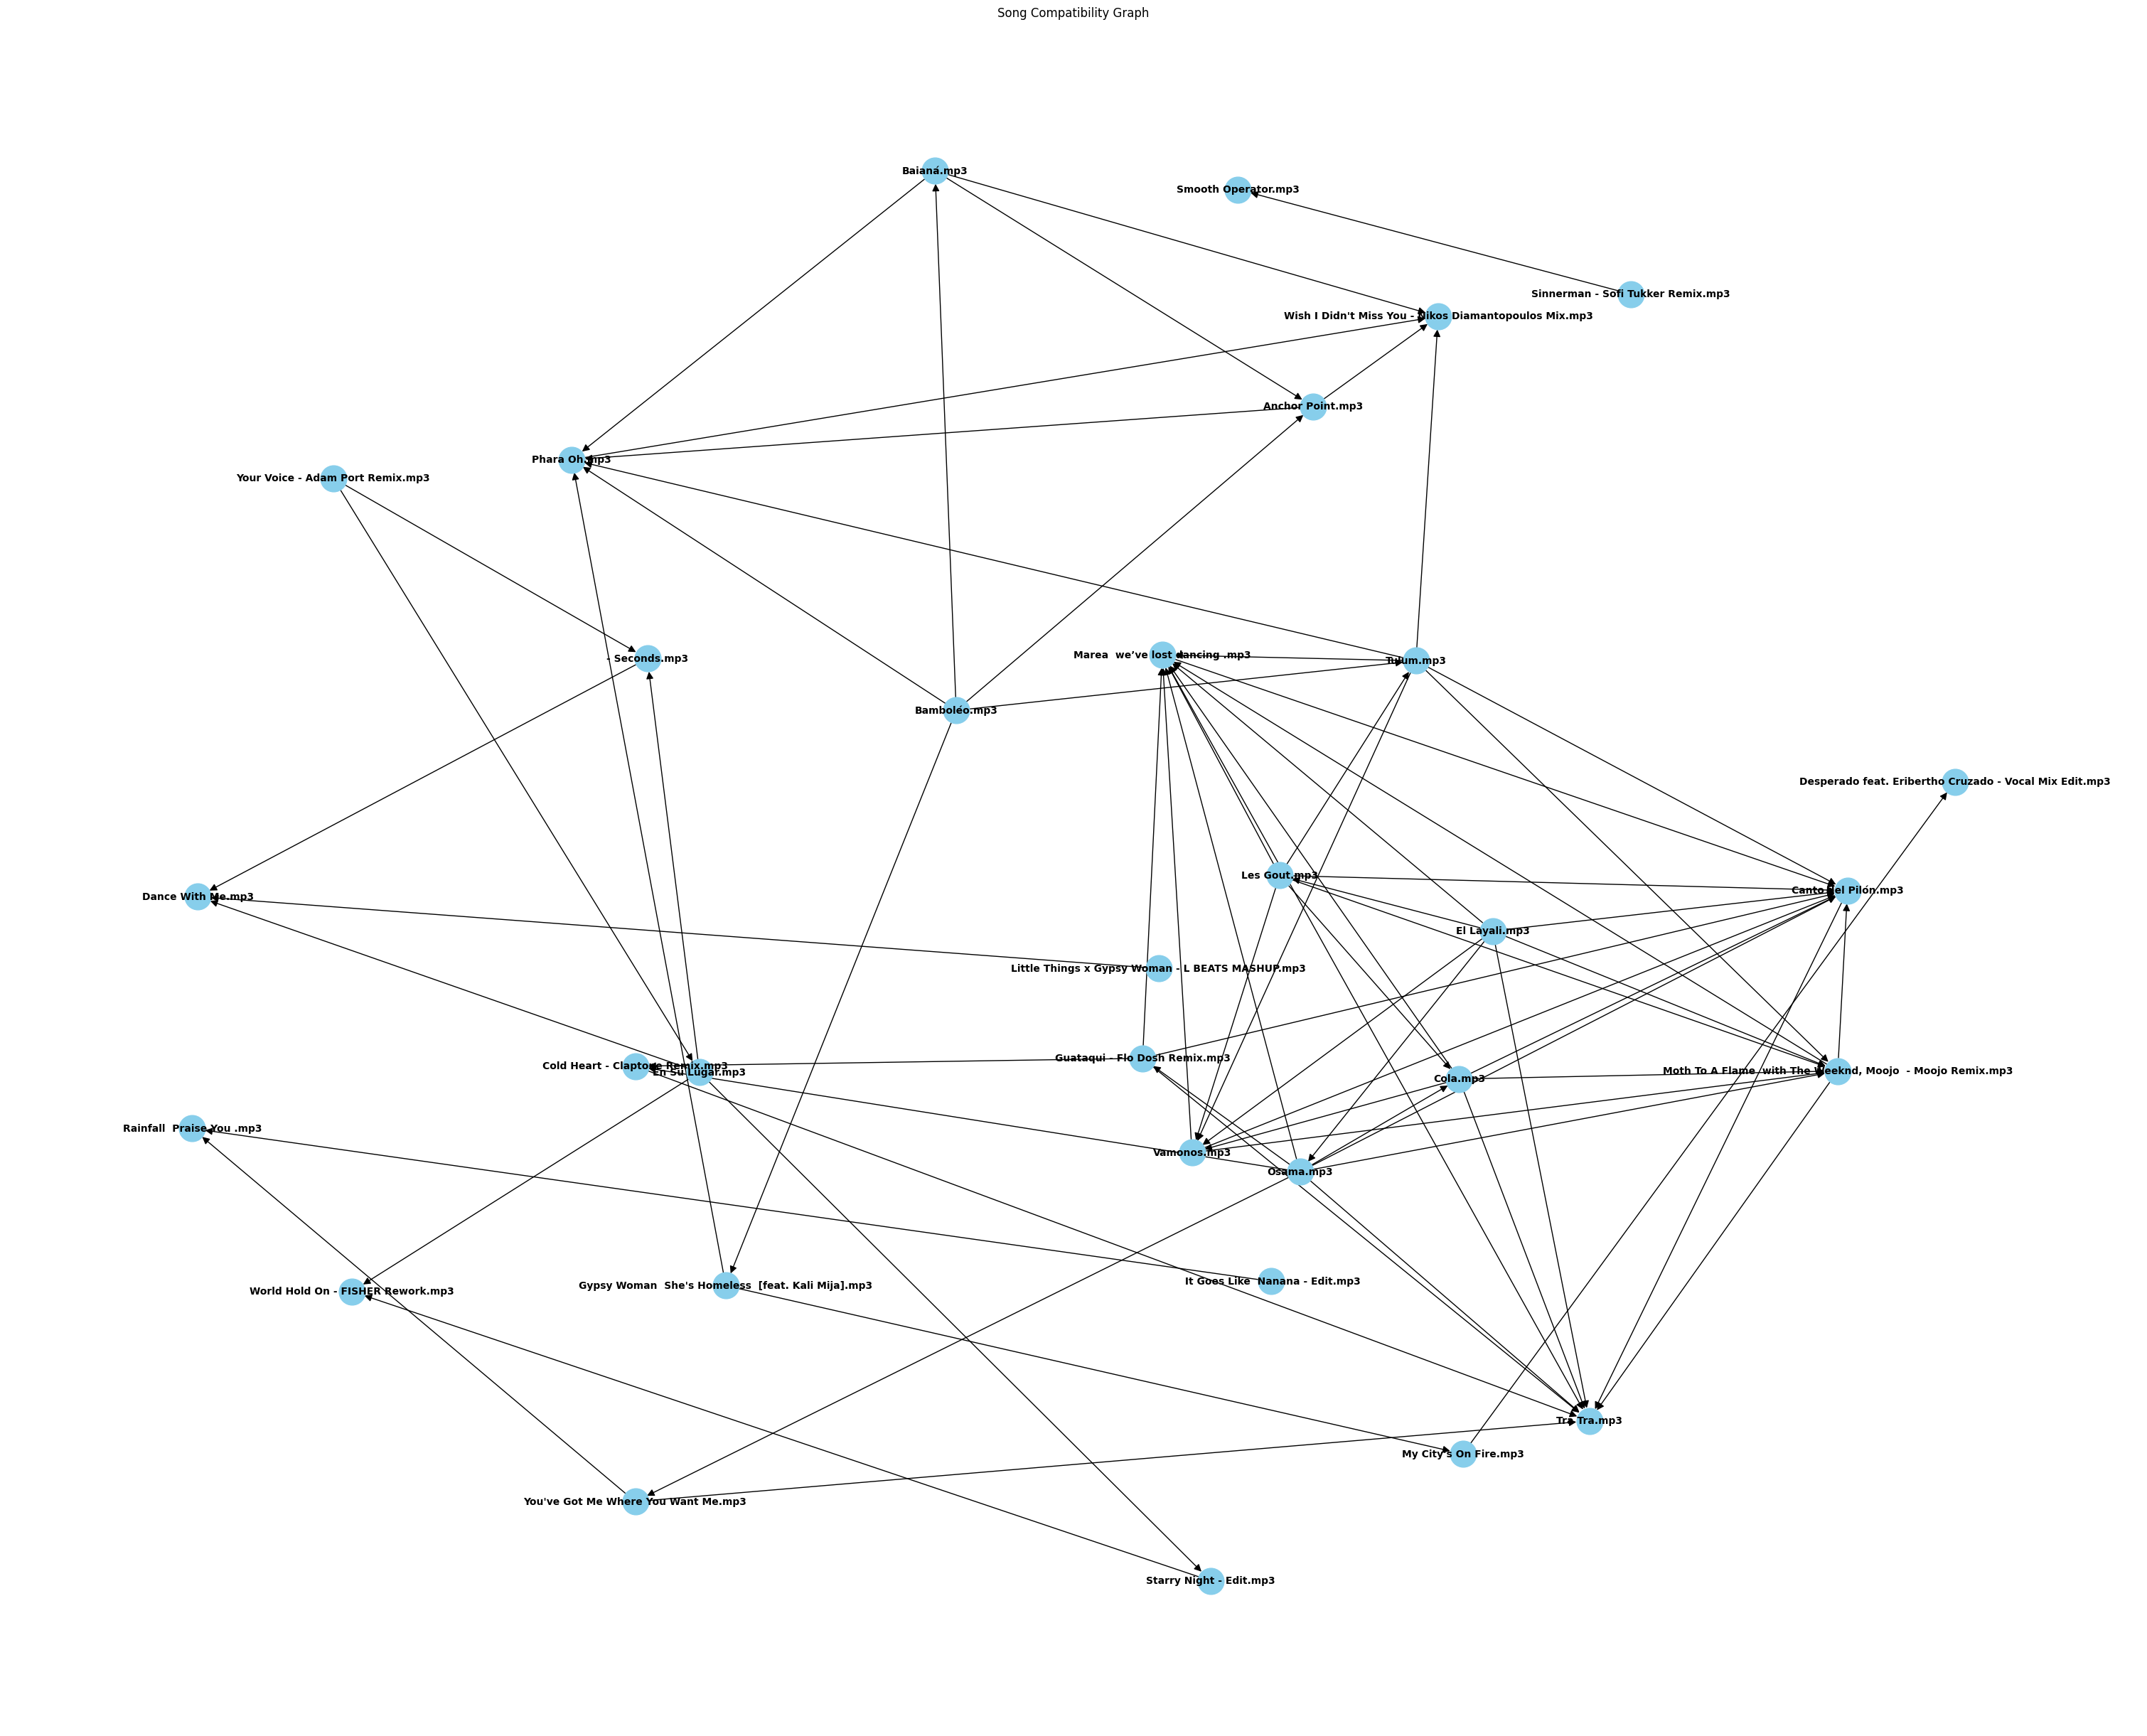

In [ ]:
#The graph visual
plt.figure(figsize=(30, 24))
pos = nx.spring_layout(G, seed=42,k=1)
nx.draw(G, pos, with_labels=True, node_size=700, node_color="skyblue", font_size=10, font_weight="bold", arrowsize=15)
plt.title("Song Compatibility Graph")
plt.show()

In [ ]:
#function to get all playlists from a graph
def dfs_paths(graph, source):
    stack = [(source, [source])]
    while stack:
        (vertex, path) = stack.pop()
        for next_node in set(graph[vertex]) - set(path):
            yield path + [next_node]
            stack.append((next_node, path + [next_node]))

In [ ]:
# Collect all paths from each node
all_paths = []
nodes = G.nodes()
for song in nodes:
    paths = list(dfs_paths(G, song))
    all_paths.extend(paths)

print("Longest playlists with properties:\n")

longest_3_paths = sorted(all_paths, key=len, reverse=True)[:3]
longest_paths = sorted(all_paths, key=len, reverse=True)

# Print the 3 longest playlists
for idx, path in enumerate(longest_3_paths, 1):
    # Print playlist number and length
    print(f"Playlist {idx} (Length: {len(path)} songs):")

    # Print the properties for each song in the playlist
    for song in path:
        camelot_key, bpm, energy = songFeaturesDict[song]
        print(f"  - {song}: Camelot Key: {camelot_key}, BPM: {bpm}, Energy: {energy}")
    print()  # Add a blank line between playlists

Longest playlists with properties:

Playlist 1 (Length: 8 songs):
  - El Layali.mp3: Camelot Key: 4B, BPM: 122.74971008300781, Energy: 0.22759780287742615
  - Osama.mp3: Camelot Key: 4A, BPM: 123.97650146484375, Energy: 0.2279874086380005
  - Cola.mp3: Camelot Key: 3A, BPM: 122.8130111694336, Energy: 0.2884198725223541
  - Vamonos.mp3: Camelot Key: 4A, BPM: 121.8157730102539, Energy: 0.30077898502349854
  - Moth To A Flame  with The Weeknd, Moojo  - Moojo Remix.mp3: Camelot Key: 4A, BPM: 122.70040893554688, Energy: 0.3083447515964508
  - Marea  we’ve lost dancing .mp3: Camelot Key: 4A, BPM: 123.82176208496094, Energy: 0.31855034828186035
  - Canto del Pilón.mp3: Camelot Key: 4A, BPM: 122.95501708984375, Energy: 0.34006208181381226
  - Tra Tra.mp3: Camelot Key: 4A, BPM: 124.95720672607422, Energy: 0.37215328216552734

Playlist 2 (Length: 8 songs):
  - El Layali.mp3: Camelot Key: 4B, BPM: 122.74971008300781, Energy: 0.22759780287742615
  - Les Gout.mp3: Camelot Key: 4A, BPM: 120.8295364

In [ ]:
# Function to extract vector features from a song using librosa
def get_song_embedding(song_path):
    y, sr = librosa.load(song_path, sr=None)

    # Extract MFCCs
    mfcc = librosa.feature.mfcc(y=y, sr=sr)
    mfcc_mean = np.mean(mfcc, axis=1)

    # Extract Chroma features
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    chroma_mean = np.mean(chroma, axis=1)

    # Extract Spectral Contrast
    spec_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    spec_contrast_mean = np.mean(spec_contrast, axis=1)

    # Combine all features into a single embedding vector
    embedding = np.hstack([mfcc_mean, chroma_mean, spec_contrast_mean])

    return embedding

# Function to move numpy embeddings to PyTorch tensors and place on the right device (CPU or GPU)
def numpy_to_tensor(np_array):
    tensor = torch.tensor(np_array, dtype=torch.float32).to(device)
    return tensor

# Function to calculate cosine similarity using PyTorch
def cosine_similarity_tensors(embedding1, embedding2):
    similarity = F.cosine_similarity(embedding1, embedding2)
    return similarity.item()

# Function to calculate playlist rating based on closeness of consecutive songs
def rate_playlist(playlist, folder_path):
    playlist_embedding = []

    for song in playlist:
        song_path = f"{folder_path}/{song}"  # Assuming song names in playlist are filenames
        embedding = get_song_embedding(song_path)
        # Convert embedding to tensor and move to device (CPU or GPU)
        playlist_embedding.append(numpy_to_tensor(embedding))

    # Compute the closeness of consecutive songs using tensors (on CPU or GPU)
    closeness_sum = 0
    for i in range(len(playlist_embedding) - 1):
        song1_embedding = playlist_embedding[i].unsqueeze(0)  # Add batch dimension
        song2_embedding = playlist_embedding[i + 1].unsqueeze(0)  # Add batch dimension
        closeness = cosine_similarity_tensors(song1_embedding, song2_embedding)
        closeness_sum += closeness

    return closeness_sum

# Function to rate all playlists using parallel processing
def rate_all_playlists(all_playlists, folder_path, songFeaturesDict):
    playlist_ratings = {}
    playlist_no = 0

    # Use ThreadPoolExecutor for parallel rating
    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = {executor.submit(rate_playlist, playlist, folder_path): playlist for playlist in all_playlists}

        for future in concurrent.futures.as_completed(futures):
            playlist = futures[future]
            try:
                rating = future.result()
                playlist_ratings[tuple(playlist)] = rating
                print(f"Playlist no: {playlist_no} is rated")
            except Exception as e:
                print(f"Error rating playlist {playlist}: {e}")
            playlist_no += 1

    # Sort playlists by rating in descending order
    sorted_playlists = sorted(playlist_ratings.items(), key=lambda x: x[1], reverse=True)

    # Print top 3 playlists
    print("\nTop 3 Playlists:")
    for playlist, rating in sorted_playlists[:3]:
        print(f"Playlist Rating: {(rating/len(playlist))*100} out of 100")
        for song in playlist:
            camelot_key, bpm, energy = songFeaturesDict[song]
            print(f"  - {song}: Camelot Key: {camelot_key}, BPM: {bpm}, Energy: {energy}")

    return sorted_playlists[:3]

# Main process to handle filtering and rating
def process_playlists(longest_paths, folder_path, songFeaturesDict):
    top_playlists = []
    filtered_playlists = []
    if len(longest_paths) > 3:
      max_length = len(longest_paths[0])
      while len(longest_paths[0]) == max_length and longest_paths != []:
        filtered_playlists.append(longest_paths.pop(0))
      if not len(filtered_playlists) > 2:
        for i in range(10):
          if len(longest_paths) > 0:
            filtered_playlists.append(longest_paths.pop(0))
          else:
            break
        # Rate the filtered playlists
      top_playlists = rate_all_playlists(filtered_playlists, folder_path, songFeaturesDict)
    else:
        top_playlists = all_paths
        print("The playlist you gave is too short or very incompatible!")

    return top_playlists

In [ ]:
top_playlists = process_playlists(longest_paths, folder_path, songFeaturesDict)

Playlist no: 0 is rated
Playlist no: 1 is rated
Playlist no: 2 is rated

Top 3 Playlists:
Playlist Rating: 85.2345421910286 out of 100
  - El Layali.mp3: Camelot Key: 4B, BPM: 122.74971008300781, Energy: 0.22759780287742615
  - Les Gout.mp3: Camelot Key: 4A, BPM: 120.82953643798828, Energy: 0.26179900765419006
  - Tulum.mp3: Camelot Key: 5A, BPM: 120.91927337646484, Energy: 0.27514025568962097
  - Vamonos.mp3: Camelot Key: 4A, BPM: 121.8157730102539, Energy: 0.30077898502349854
  - Moth To A Flame  with The Weeknd, Moojo  - Moojo Remix.mp3: Camelot Key: 4A, BPM: 122.70040893554688, Energy: 0.3083447515964508
  - Marea  we’ve lost dancing .mp3: Camelot Key: 4A, BPM: 123.82176208496094, Energy: 0.31855034828186035
  - Canto del Pilón.mp3: Camelot Key: 4A, BPM: 122.95501708984375, Energy: 0.34006208181381226
  - Tra Tra.mp3: Camelot Key: 4A, BPM: 124.95720672607422, Energy: 0.37215328216552734
Playlist Rating: 84.92145612835884 out of 100
  - El Layali.mp3: Camelot Key: 4B, BPM: 122.7497

In [ ]:
selected_playlist_no = int(input("Which playlist satisfies you?: ")) - 1

Which playlist satisfies you?: 1


In [ ]:
selected_playlist=top_playlists[selected_playlist_no][0]
#selected_playlist=longest_3_paths[int(selected_playlist_no)]

In [ ]:
# Initialize the MusicGen model (use 'small', 'medium', or 'large' based on GPU memory)
model = MusicGen.get_pretrained('facebook/musicgen-melody')  # 'melody' model allows for audio interpolation
model.set_generation_params(duration=15)  # Adjust the duration for each segment

# Load MERT model and processor
mert_model = AutoModel.from_pretrained("m-a-p/MERT-v1-330M", trust_remote_code=True)
mert_processor = AutoProcessor.from_pretrained("m-a-p/MERT-v1-330M", trust_remote_code=True)
mert_processor.sampling_rate = 32000

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


state_dict.bin:   0%|          | 0.00/2.77G [00:00<?, ?B/s]

Downloading: "https://dl.fbaipublicfiles.com/demucs/hybrid_transformer/955717e8-8726e21a.th" to /root/.cache/torch/hub/checkpoints/955717e8-8726e21a.th
100%|██████████| 80.2M/80.2M [00:00<00:00, 171MB/s]


spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

compression_state_dict.bin:   0%|          | 0.00/236M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


config.json:   0%|          | 0.00/2.03k [00:00<?, ?B/s]

configuration_MERT.py:   0%|          | 0.00/5.26k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/m-a-p/MERT-v1-330M:
- configuration_MERT.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_MERT.py:   0%|          | 0.00/18.0k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/m-a-p/MERT-v1-330M:
- modeling_MERT.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


pytorch_model.bin:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


preprocessor_config.json:   0%|          | 0.00/212 [00:00<?, ?B/s]

In [ ]:
def get_bpm_from_segment(audio_segment, samplerate):
    """
    Calculate BPM for a provided audio segment.

    :param audio_segment: Numpy array containing the audio data.
    :param samplerate: Sampling rate of the audio data.
    :return: BPM value for the segment, or None if an error occurred.
    """
    try:
        # Initialize aubio parameters
        win_s = 512
        hop_s = win_s // 2
        tempo_o = aubio.tempo("default", win_s, hop_s, samplerate)
        beats = []

        # Process the audio segment in chunks
        for i in range(0, len(audio_segment), hop_s):
            samples = audio_segment[i:i+hop_s]
            is_beat = tempo_o(samples.astype(np.float32))
            if is_beat:
                beat_samples = tempo_o.get_last_s()
                beat_time = beat_samples / float(samplerate)
                beats.append(beat_time)

        # Get BPM
        bpm_value = tempo_o.get_bpm()

        # Ensure BPM is valid
        if bpm_value is None or bpm_value == 0:
            raise ValueError("BPM could not be detected.")

        return bpm_value

    except ValueError as e:
        print(f"Error processing BPM: {e}")
    except Exception as e:
        print(f"An unexpected error occurred while processing the segment: {e}")

    # Return None if an error occurred
    return None


In [ ]:
def generate_transitioned_music_with_gen(song_paths, filename, model, mert_model, mert_processor):
    sr = 32000  # Sample rate (set accordingly based on your files)
    crossfade_duration = 10

    # Function to break audio into segments
    def segment_audio(y, sr, segment_length=10):
        segments = []
        segment_samples = segment_length * sr
        for i in range(0, len(y), segment_samples):
            if i + segment_samples <= len(y):
                segments.append(y[i:i+segment_samples])
        return segments

    # Function to extract MERT embeddings
    def extract_mert_embedding(segment, sr):
        # Prepare input for the MERT model
        inputs = mert_processor(segment, sampling_rate=sr, return_tensors="pt", padding=True)

        # Get MERT embeddings
        with torch.no_grad():
            embeddings = mert_model(**inputs).last_hidden_state.mean(dim=1).cpu().numpy()

        return embeddings.squeeze()

    # Function to extract features from a segment (MFCCs, spectral, energy, and MERT)
    def extract_features(segment, sr):
        # Extract MFCCs
        #mfccs = librosa.feature.mfcc(y=segment, sr=sr, n_mfcc=13)
        #mfccs_mean = np.mean(mfccs.T, axis=0)

        # Extract Spectral Centroid
        spectral_centroid = librosa.feature.spectral_centroid(y=segment, sr=sr)
        spectral_centroid_mean = np.mean(spectral_centroid.T, axis=0)

        # Extract Spectral Bandwidth
        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=segment, sr=sr)
        spectral_bandwidth_mean = np.mean(spectral_bandwidth.T, axis=0)

        # Extract Chroma Features
        chroma = librosa.feature.chroma_stft(y=segment, sr=sr)
        chroma_mean = np.mean(chroma.T, axis=0)

        # Extract Energy
        rms = librosa.feature.rms(y=segment)
        energy_mean = np.mean(rms.T, axis=0)

        # Extract Tempo and Beat
        tempo, _ = librosa.beat.beat_track(y=segment, sr=sr)

        # Extract MERT embedding
        mert_embedding = extract_mert_embedding(segment, sr)

        # Ensure MERT embedding is 1D
        mert_embedding_flat = mert_embedding.flatten()

        # Combine all features into a single feature vector
        features = np.concatenate((
            mert_embedding_flat,
            #mfccs_mean,
            spectral_centroid_mean,
            spectral_bandwidth_mean,
            chroma_mean,
            energy_mean,
            tempo
        ))

        return features

    segment_length = 10  # segment length in seconds
    slide_window = 4  # sliding window length in seconds

    target_sr = 32000
    # Resample audio to the target sampling rate if needed

    # Calculate the number of samples corresponding to 30 seconds and 2 seconds sliding window
    samples_30s = int(60 * target_sr)
    samples_10s = int(segment_length * target_sr)
    samples_2s = int(slide_window * target_sr)




    def sliding_window_segments(audio, sr, segment_length, slide_window):
        segments = []
        for start in range(0, len(audio) - samples_10s + 1, samples_2s):
            segment = audio[start:start + samples_10s]
            segments.append(segment)
        return segments

    # Helper function to apply a low-pass filter
    def apply_lowpass_filter(audio, cutoff_freq, sr, order=4):
        nyquist = 0.5 * sr
        normal_cutoff = cutoff_freq / nyquist
        b, a = butter(order, normal_cutoff, btype='low', analog=False)
        return lfilter(b, a, audio)

    def match_beats(transition_segment, crossfade_segment, sr):
        """
        Adjusts the tempo of the transition segment to match the beats of the crossfade segment.
        :param transition_segment: Audio data of the transition segment.
        :param crossfade_segment: Audio data of the crossfade segment.
        :param sr: Sampling rate.
        :return: Beat-matched transition segment.
        """

        # Detect beats in the crossfade segment
        _, crossfade_beats = librosa.beat.beat_track(y=crossfade_segment, sr=sr)
        crossfade_beats_times = librosa.frames_to_time(crossfade_beats, sr=sr)

        # Detect beats in the transition segment
        _, transition_beats = librosa.beat.beat_track(y=transition_segment, sr=sr)
        transition_beats_times = librosa.frames_to_time(transition_beats, sr=sr)

        # Only proceed with beat matching if both beat arrays are non-empty
        if len(crossfade_beats_times) > 0 and len(transition_beats_times) > 0:
            # Calculate the tempo of each segment
            crossfade_tempo = float(librosa.beat.tempo(y=crossfade_segment, sr=sr)[0])
            transition_tempo = float(librosa.beat.tempo(y=transition_segment, sr=sr)[0])

            # Time-stretch the transition segment to match the crossfade segment's tempo
            tempo_ratio = crossfade_tempo / transition_tempo
            transition_segment_matched = librosa.effects.time_stretch(transition_segment, rate=tempo_ratio)

            # Find the closest beat in the transition segment to match the first beat in the crossfade segment
            start_offset = min(crossfade_beats_times, key=lambda x: abs(x - transition_beats_times[0]))
            start_sample = int(start_offset * sr)

            # Adjust the transition segment to start from the calculated beat offset
            adjusted_transition_segment = transition_segment_matched[start_sample:]

            # Trim or pad the adjusted transition segment to match the crossfade segment's length
            if len(adjusted_transition_segment) > len(crossfade_segment):
                adjusted_transition_segment = adjusted_transition_segment[:len(crossfade_segment)]
            else:
                adjusted_transition_segment = np.pad(adjusted_transition_segment, (0, len(crossfade_segment) - len(adjusted_transition_segment)))
        else:
            # Fallback: If no beats were detected, use the start of the transition segment directly
            adjusted_transition_segment = np.pad(transition_segment[:len(crossfade_segment)],
                                                (0, max(0, len(crossfade_segment) - len(transition_segment))))

        return adjusted_transition_segment

    def frequency_domain_blend(segment1, segment2, sr, crossfade_duration):
        """
        Perform frequency domain blending for smooth crossfade.
        :param segment1: First audio segment.
        :param segment2: Second audio segment.
        :param sr: Sampling rate.
        :param crossfade_duration: Crossfade duration in seconds.
        :return: Blended audio.
        """
        crossfade_samples = int(crossfade_duration * sr)

        # Ensure segments are at least as long as the crossfade duration
        if len(segment1) < crossfade_samples or len(segment2) < crossfade_samples:
            raise ValueError("Segments must be at least as long as the crossfade duration.")

        # STFT parameters
        n_fft = 2048
        hop_length = 512

        # Compute STFT for overlapping segments
        stft1 = librosa.stft(segment1[-crossfade_samples:], n_fft=n_fft, hop_length=hop_length)
        stft2 = librosa.stft(segment2[:crossfade_samples], n_fft=n_fft, hop_length=hop_length)

        # Create a linear blend envelope
        blend_envelope = np.linspace(0, 1, stft1.shape[1])  # Shape (time_frames,)
        blend_envelope = blend_envelope[None, :]  # Reshape to (frequency_bins, time_frames)

        # Compute blended magnitude
        blended_magnitude = (1 - blend_envelope) * np.abs(stft1) + blend_envelope * np.abs(stft2)

        # Use phase from the first segment for continuity
        blended_phase = np.angle(stft1)

        # Combine blended magnitude with the phase
        blended_stft = blended_magnitude * np.exp(1j * blended_phase)

        # Perform ISTFT to reconstruct the crossfade segment
        blended_audio = librosa.istft(blended_stft, hop_length=hop_length)

        # Combine the non-overlapping parts of the audio
        output_audio = np.concatenate([
            segment1[:-crossfade_samples],  # Non-overlapping part of segment1
            blended_audio,                 # Crossfade segment
            segment2[crossfade_samples:]   # Non-overlapping part of segment2
        ])

        return output_audio



    # Load the first song and initialize combined audio
    first_song_path = os.path.join(folder_path, song_paths[0])
    combined_audio = librosa.load(first_song_path, sr=sr)[0]
    combined_audio = librosa.resample(combined_audio, orig_sr=sr, target_sr=target_sr)





    # Iterate over pairs of songs to add transitions
    for i in range(1, len(song_paths)):
        next_song_path = os.path.join(folder_path, song_paths[i])
        y_next, _ = librosa.load(next_song_path, sr=sr)
        y_next = librosa.resample(y_next, orig_sr=sr, target_sr=target_sr)

        y_last_30s = combined_audio[-int(60 * target_sr):]
        y_next_first_30s = y_next[:int(60 * target_sr)]

        segments1 = sliding_window_segments(y_last_30s, target_sr, segment_length, slide_window)

        segments2 = sliding_window_segments(y_next_first_30s, target_sr, segment_length, slide_window)

        segments1_bpms=[get_bpm_from_segment(segment,32000) for segment in segments1]
        segments2_bpms=[get_bpm_from_segment(segment,32000) for segment in segments2]


        best_segment_index = (0, 0)
        lowest_similarity = float('inf')
        for j in range(len(segments1_bpms)):
            for k in range(len(segments2_bpms)):
                bpm_difference = abs(segments1_bpms[j] - segments1_bpms[k])
                if bpm_difference < lowest_similarity:
                    lowest_similarity = bpm_difference
                    best_segment_index = (j, k)




        #features1 = [extract_features(segment, target_sr) for segment in tqdm.tqdm(segments1, desc=f"Processing last 30s of song {i}")]
        #features2 = [extract_features(segment, target_sr) for segment in tqdm.tqdm(segments2, desc=f"Processing first 30s of song {i+1}")]

        #best_similarity = float('-inf')
        #best_segment_index = (0, 0)
        #for j, feat1 in enumerate(features1):
            #for k, feat2 in enumerate(features2):
                #similarity = cosine(feat1, feat2)
                #if similarity > best_similarity:
                    #best_similarity = similarity
                    #best_segment_index = (j, k)

        best_segment1 = segments1[best_segment_index[0]]
        best_segment2 = segments2[best_segment_index[1]]
        crossfaded_segment = frequency_domain_blend(best_segment1, best_segment2, target_sr, crossfade_duration)






        crossfade_samples = int(crossfade_duration * target_sr)





        # Generate additional transition audio using the model
        # Convert to tensor and ensure FloatTensor type for compatibility
        segment_crossfade_tensor= torch.tensor(crossfaded_segment,dtype=torch.float32).unsqueeze(0).unsqueeze(0).to('cuda')  # Shape: [1, 1, T]
        segment_A_tensor = torch.tensor(best_segment1).unsqueeze(0).unsqueeze(0).to('cuda').float()  # Shape: [1, 1, T]
        segment_B_tensor = torch.tensor(best_segment2).unsqueeze(0).unsqueeze(0).to('cuda').float()  # Shape: [1, 1, T]

        prompt = segment_crossfade_tensor
        model.set_generation_params(temperature=0.5, top_p=0.9)
        with torch.no_grad():
            transition_audio_ab = model.generate_continuation(prompt, prompt_sample_rate=sr).squeeze().detach().cpu().numpy()
        transition_audio_ab_resampled = librosa.resample(transition_audio_ab, orig_sr=sr, target_sr=target_sr) if sr != target_sr else transition_audio_ab

        # Adjust transition audio length
        if len(transition_audio_ab_resampled) < len(crossfaded_segment):
            transition_audio_ab_resampled = np.pad(transition_audio_ab_resampled, (0, len(crossfaded_segment) - len(transition_audio_ab_resampled)), 'constant')
        else:
            transition_audio_ab_resampled = transition_audio_ab_resampled[-len(crossfaded_segment):]

        # Low-pass filter and volume envelope on transition audio
        transition_audio_ab_filtered = apply_lowpass_filter(transition_audio_ab_resampled, cutoff_freq=2000, sr=target_sr)
        half_length = len(crossfaded_segment) // 2
        volume_envelope = np.concatenate([
            0.5 * (1 - np.cos(np.linspace(0, np.pi, half_length))),
            0.5 * (1 + np.cos(np.linspace(0, np.pi, len(crossfaded_segment) - half_length)))
        ])
        transition_audio_ab_adjusted = transition_audio_ab_filtered * volume_envelope

        beat_matched_transition_segment = match_beats(transition_audio_ab_adjusted, crossfaded_segment, sr)

        # Enhanced crossfade segment
        enhanced_crossfaded_segment = crossfaded_segment + beat_matched_transition_segment

        # Concatenate with the combined audio
        start_of_best_segment1 = best_segment_index[0] * int(slide_window * target_sr)
        combined_audio = np.concatenate([
            combined_audio[:-(len(y_last_30s) - start_of_best_segment1)],
            enhanced_crossfaded_segment,
            y_next[best_segment_index[1] * int(slide_window * target_sr) + crossfade_duration * sr:]
        ])

    # Save the result
    wav_path = "/content/combined_audio.wav"
    sf.write(wav_path, combined_audio, target_sr)

    # Convert WAV to MP3
    mp3_path = "/content/" + filename
    audio_segment = AudioSegment.from_wav(wav_path)
    audio_segment.export(mp3_path, format="mp3")

    print(f"Combined audio saved as MP3: {mp3_path}")
    return mp3_path
    generate_transitioned_music_with_gen(selected_playlist,"fullPlaylist.mp3",model,mert_model,mert_processor)

In [ ]:
generate_transitioned_music_with_gen(selected_playlist,"fullPlaylist.mp3",model,mert_model,mert_processor)

<ipython-input-25-16d7e172cf40>:117: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  crossfade_tempo = float(librosa.beat.tempo(y=crossfade_segment, sr=sr)[0])
<ipython-input-25-16d7e172cf40>:118: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  transition_tempo = float(librosa.beat.tempo(y=transition_segment, sr=sr)[0])


Combined audio saved as MP3: /content/fullPlaylist.mp3


'/content/fullPlaylist.mp3'